## SA Python implementation

- [SA for TSP](http://codecapsule.com/2010/04/06/simulated-annealing-traveling-salesman/) from Emmanuel Goossaert 
- [Python Package PyGenSA by by Sylvain Gubian](https://github.com/sgubianpm/pygensa)

## Simulated annealing with restart applied to the traveling salesman problem.

The data needs to be in cvs format and the coordinates of the cities are
longitude and latitude. Thus, any gps data taken on the internet can
serve as input.

Once the annealing is done, the cities are plotted according to their
coordinates using the matplotlib package. The cities are then linked as to
show the order of visit in the final solution. Also, the evolution of the
tested and shortest distances is plotted.

Starting simulated annealing, type CTRL+C to interrupt...
Improvement:                70 %
Time:                       86 sec
Initial distance:        75506 km
Optimal distance:        22820 km
CPU times: user 1min 34s, sys: 1.78 s, total: 1min 36s
Wall time: 1min 36s


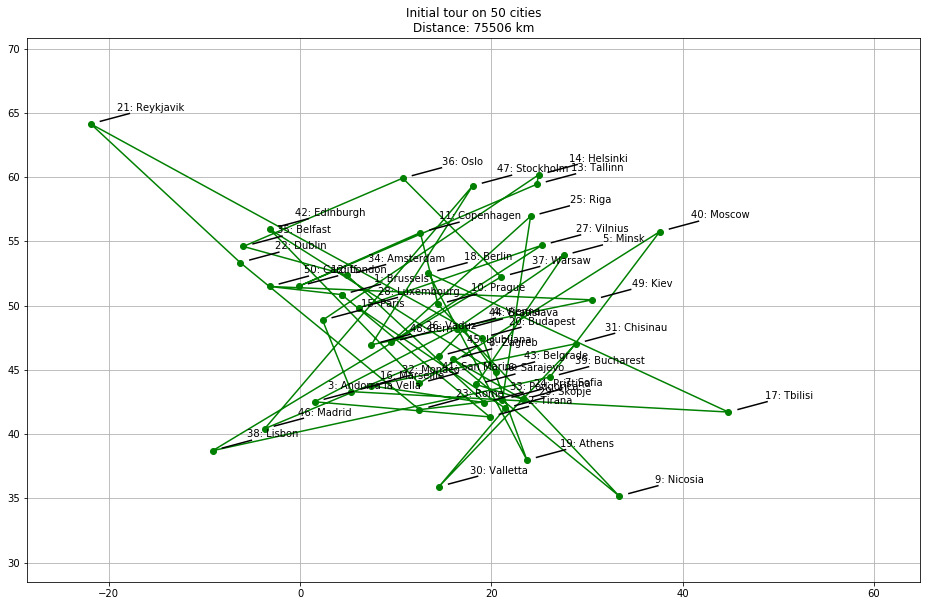

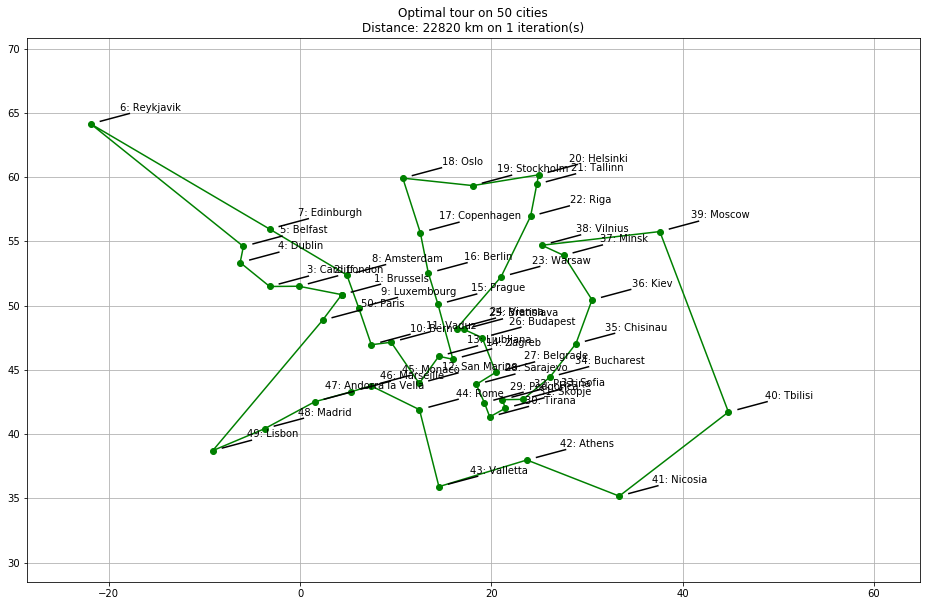

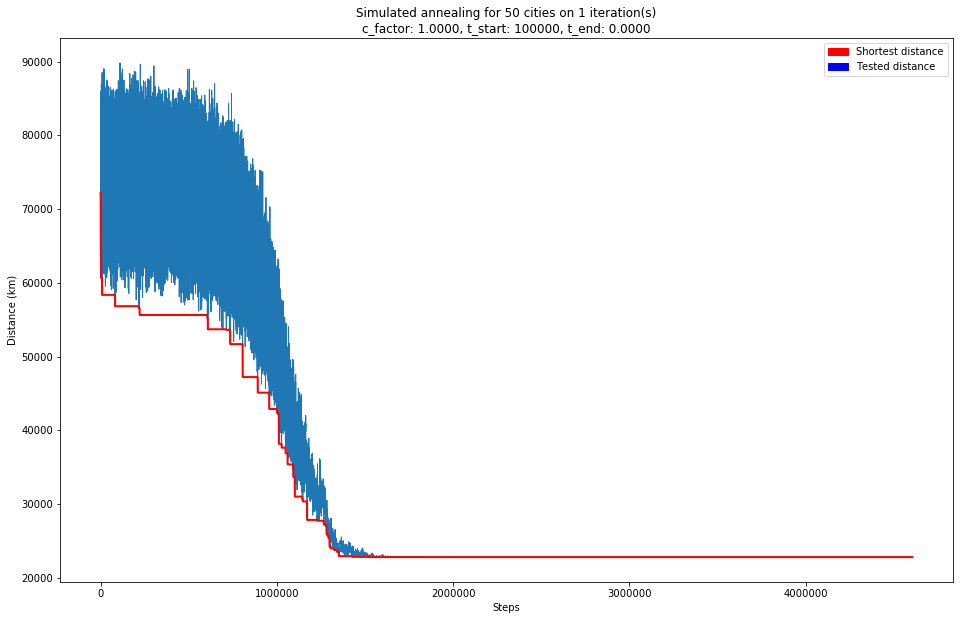

In [ ]:
%%time
"""
Simulated annealing with restart applied to the traveling salesman problem.

The data needs to be in cvs format and the coordinates of the cities are
longitude and latitude. Thus, any gps data taken on the internet can
serve as input.

Once the annealing is done, the cities are plotted according to their
coordinates using the matplotlib package. The cities are then linked as to
show the order of visit in the final solution. Also, the evolution of the
tested and shortest distances is plotted.
"""
__docformat__ = "restructuredtext en" 

## Copyright (c) 2010 Emmanuel Goossaert 
## http://codecapsule.com/2010/04/06/simulated-annealing-traveling-salesman/
##
## This file is free software; you can redistribute it and/or modify
## it under the terms of the GNU General Public License as published by
## the Free Software Foundation; either version 3 of the License, or
## (at your option) any later version.
##
## This file is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
## GNU General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this file.  If not, see <http://www.gnu.org/licenses/>.


import csv
import sys
import math
import random
import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline 

distances_pair = []


def read_cities(filename):
    """
    Read city data from a csv file.
    """
    reader = csv.reader(open(filename)) # may raise IOError
    rows = [line for line in reader]
    cities = [City(r[2], index, r[3], float(r[0]), float(r[1])) for index, r in enumerate(rows[1:])]
    return cities


class City:
    """
    Store information regarding a city, including name and gps coordinates.
    """

    def __init__(self, name='', index=0, description='', latitude=0, longitude=0):
        self.name = name
        self.description = description
        self.latitude = latitude
        self.longitude = longitude
        self.index = index

    def __str__(self):
        return '%s %d %s %f %f' % (self.name, self.index, self.description, self.latitude, self.longitude)

    def __repr__(self):
        return self.__str__()

    def compute_distance_to_city_in_km(self, city):
        """Distance to another city using Haversine formula."""
        lat = math.radians(self.latitude - city.latitude)
        long = math.radians(self.longitude - city.longitude)
        a = math.pow(math.sin(lat/2), 2) \
           + math.cos(math.radians(self.latitude)) * math.cos(math.radians(city.latitude)) * pow(math.sin(long/2), 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        radius_earth = 6378.7 # in kilometers
        return radius_earth * c

    def distance_to_city_in_km(self, city):
        """Distance to another city using pre-computed distance."""
        global distances_pair
        if self.index != city.index:
            indices = [self.index, city.index]
            return distances_pair[max(indices)][min(indices)]
        return 0


def compute_distance_pairs(cities):
    """
    Compute all distance pairs.
    /!\ IMPORTANT: The cities must be ordered by their indices in the list.
    """
    global distances_pair
    for city_from in cities:
        distances_pair.append([0 for r in range(city_from.index)]) # create
        for city_to in cities[:city_from.index]:
            distances_pair[city_from.index][city_to.index] = city_from.compute_distance_to_city_in_km(city_to)
         

def total_distance_in_km(cities):
    distances = [cities[index].distance_to_city_in_km(cities[(index + 1) % len(cities)]) for index in range(len(cities))]
    return sum(distances)


def plot_cities(cities, figure_id):
    """Plot the cities on a plan."""
    plt.figure(figsize=(16,10));
    fig_map = plt.figure(figure_id)
    ax_map = fig_map.add_subplot(111)

    cities_x = [city.longitude for city in cities + [cities[0]]]
    cities_y = [city.latitude for city in cities + [cities[0]]]

    link = '-'
    ax_map.plot(cities_x, cities_y, 'go' + link)
    ax_map.grid()

    spacing = math.fabs(min(cities_x) - max(cities_x)) * .1
    ax_map.set_xlim(min(cities_x) - spacing, max(cities_x) + spacing * 3)
    ax_map.set_ylim(min(cities_y) - spacing, max(cities_y) + spacing)

    for index, city in enumerate(cities):
        ax_map.text(city.longitude,
                    city.latitude,
                    '%d: %s' % (index + 1, city.name),
                    withdash = True,
                    dashdirection = 1,
                    dashlength = 30,
                    rotation = 0,
                    dashrotation = 15,
                    dashpush = 10)
    return ax_map


def plot_distances(distances_current, figure_id, distances_best, ids_iteration, nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end):
    """Plot the evolution of the distance metrics."""
    # plot distances
    plt.figure(figsize=(16,10));
    fig_distances = plt.figure(figure_id)
    ax_distances = fig_distances.add_subplot(111)
    line_current = ax_distances.plot(distances_current, linewidth=1,label='Tested distance')
    line_best = ax_distances.plot(distances_best, 'r', linewidth=2,label='shortest distance')
    ax_distances.set_title('Simulated annealing for %d cities on %d iteration(s)\nc_factor: %.4f, t_start: %g, t_end: %.4f' % (nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end))

    # plot iteration steps
    y_min = min(distances_current)
    y_max = max(distances_current)
    line_iteration = None

    for step in ids_iteration[:-1]:
        line_iteration = ax_distances.plot([step, step], [y_min, y_max], 'g', linewidth=2)

    ax_distances.set_xlabel('Steps')
    ax_distances.set_ylabel('Distance (km)')

    index_legend = 3 if len(ids_iteration) > 1 else 2
    red_patch = mpatches.Patch(color='red', label='Shortest distance')
    blue_patch = mpatches.Patch(color='blue', label='Tested distance')
    plt.legend(handles=[red_patch,blue_patch])
    
    #plt.legend( [line_current, line_best, line_iteration],
    #           ['Tested distance', 'Shortest distance', 'Restart'],
     #           loc='upper right' )
   



def compute_swap_indices(index, nb_cities):
    index_previous = (index - 1 + nb_cities) % nb_cities
    index_next = (index + 1) % nb_cities
    return (index_previous, index_next)


def distance_swap(cities, index_a, index_b):
    """Compute the distance inferred by the two given indices."""
    index_A = min(index_a, index_b)
    index_B = max(index_a, index_b)
    
    (index_A_previous, index_A_next) = compute_swap_indices(index_A, len(cities))
    (index_B_previous, index_B_next) = compute_swap_indices(index_B, len(cities))
  
    distances = []
    # These two distances are common to the two sub-cases
    distances.append(cities[index_A_previous].distance_to_city_in_km(cities[index_A]))
    distances.append(cities[index_B].distance_to_city_in_km(cities[index_B_next]))
    if index_A == index_B_previous:
        # B is following A in the list: the distance between A and B must not
        # be counted twice.
        # ---x---A---B---x---
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_B]))
    else:
        # B is not following A in the list: all distances must be counted
        # ---x---A---x--- ... ---x---B---x---
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_A_next]))
        distances.append(cities[index_B_previous].distance_to_city_in_km(cities[index_B]))

    return sum(distances)


def annealing(cities, temperature_begin=1.0e+300, temperature_end=.1, cooling_factor=.99, nb_iterations=1):
    """
    Simulated annealing function, implemented with acceptance probability from
    by Kirkpatrick et al., and with restart.

    distance_best:    best solution encountered so far
    distance_current: solution used in the current simulation
    distance_new:     solution computed from the random changes to current
    """

    cities_best = cities[:]
    distance_best = total_distance_in_km(cities_best)

    distances_current = []
    distances_best = []
    ids_iteration = []

    try:
        for iteration in range(nb_iterations):
            # the search is restarted at every iteration from
            # the best know solution
            temperature = temperature_begin
            cities_current = cities_best[:]
            distance_current = distance_best
            distance_new = distance_best
            cities_new = cities_best[:]

            step = 0
            while temperature > temperature_end:
                # compute the indices of the two cities to swap by random,
                # but never touch the first city (it does not need to change)
                index = random.sample(range(len(cities_new) - 1), 2)
                index[0] += 1
                index[1] += 1

                # optimize by recomputing only the changed distances
                swap_before = distance_swap(cities_new, index[0], index[1])
                cities_new[index[0]], cities_new[index[1]] = cities_new[index[1]], cities_new[index[0]]
                swap_after = distance_swap(cities_new, index[0], index[1])

                # compute the new distance
                # recomputing all is bad: distance_new = total_distance_in_km(cities_new)
                distance_new = distance_new - swap_before + swap_after

                # acceptance probability by Kirkpatrick et al.
                diff = distance_new - distance_current
                if diff < 0 or  math.exp( -diff / temperature ) > random.random():
                    cities_current = cities_new[:]
                    distance_current = distance_new
                else:
                    # reset cities and distance
                    distance_new = distance_current
                    cities_new = cities_current[:]

                # update the best if current solution is better
                # not part of the annealing itself, just used for the restart
                if distance_current < distance_best:
                    cities_best = cities_current[:]
                    distance_best = distance_current

                if True:
                    # if step % 100 == 0:
                    # uncomment to enable systematic sampling: 1 point every 100th
                    distances_current.append(distance_current)
                    distances_best.append(distance_best)
                temperature = temperature * cooling_factor
                step = step + 1

            ids_iteration.append(len(distances_current))

    except KeyboardInterrupt as e:
        print ("Interrupted on user demand.")
        print ('performed iterations: %d' % iteration )

    return cities_best, distances_current, distances_best, ids_iteration


def display_usage():
    print ('usage: %s input [plot] [nb_ite] [nb_cities] [c_factor] [t_start] [t_end] [r_seed]' % sys.argv[0])
    print ('  input: input CSV file containing the city coordinates')
    print ('  output: \'plot\' to display figures to screen, \'file\' to save')
    print ('          figures to files (default: \'plot\')')
    print ('  nb_ite: number of iterations in the restart process (default: 1)')
    print ('  nb_cities: number of cities read from the input file (n first lines,')
    print ('             default: all cities in file)')
    print ('  c_factor: cooling factor, float number in (0,1) (default: .95)')
    print ('  t_start: initial temperature (default: 1.0e+50, maximum: 1.0e+300)')
    print ('  t_end: temperature at which the process will be stopped (default: .1)')
    print ('         must be smaller than t_start')
    print ('  r_seed: seed for the random number generator (default: standard')
    print ('          \'library\'s default)')


if __name__ == '__main__':

    if len(sys.argv) < 2:
        display_usage()
        sys.exit(0)

    input             = sys.argv[1]
    input = './cities.csv'
    plot              = sys.argv[2]        if len(sys.argv) > 2 else 'plot'
    nb_iterations     = int(sys.argv[3])   if len(sys.argv) > 3 else 1
    nb_cities         = int(sys.argv[4])   if len(sys.argv) > 4 else -1
    cooling_factor    = float(sys.argv[5]) if len(sys.argv) > 5 else .999995
    temperature_start = float(sys.argv[6]) if len(sys.argv) > 6 else 1.0e+5
    temperature_end   = float(sys.argv[7]) if len(sys.argv) > 7 else .00001
    random_seed       = float(sys.argv[8]) if len(sys.argv) > 8 else -1
    
    if random_seed == -1:
        random.seed() 
    else:
        random.seed(random_seed)

    time_begin = time.time()
    cities = read_cities(input)
    compute_distance_pairs(cities)

    nb_cities = len(cities) if nb_cities <= 0 else nb_cities

    print ('Starting simulated annealing, type CTRL+C to interrupt...')

    cities = cities[:nb_cities]
    (cities_new, distances_current, distances_best, ids_iteration) = annealing(cities, temperature_start, temperature_end, cooling_factor, nb_iterations)
    time_end = time.time()

    distance_begin = total_distance_in_km(cities)
    distance_end = total_distance_in_km(cities_new)
    print ('Improvement:          %8.0f %%'  % (100 * (distance_begin - distance_end) / distance_begin))
    print ('Time:                 %8.0f sec' % (time_end - time_begin))
    print ('Initial distance:     %8.0f km'  % distance_begin)
    print ('Optimal distance:     %8.0f km'  % distance_end)

    ax_map = plot_cities(cities, 1)
    ax_map.set_title('Initial tour on %d cities\nDistance: %.0f km' % (len(cities), distance_begin))

    if nb_iterations:
        ax_map = plot_cities(cities_new, 2)
        ax_map.set_title('Optimal tour on %d cities\nDistance: %.0f km on %d iteration(s)' % (len(cities), distance_end, nb_iterations))
        plot_distances(distances_current, 3, distances_best, ids_iteration, len(cities), nb_iterations, cooling_factor, temperature_start, temperature_end)

    if plot == 'plot':
        plt.show()
    else:
        # save in files
        format = 'png'

        parameters = { 'nb_cities': len(cities),
                       'nb_ite': nb_iterations,
                       'c_factor': cooling_factor,
                       't_start': temperature_start,
                       't_end': temperature_end,
                       'format': format
                      }
        
        plt.figure(1)
        plt.savefig('tsp_cities_c%(nb_cities)d_init_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)
        plt.figure(2)
        plt.savefig('tsp_cities_c%(nb_cities)d_i%(nb_ite)d_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)
        plt.figure(3)
        plt.savefig('tsp_distances_c%(nb_cities)d_i%(nb_ite)d_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)


![](tsp_cities_c50_i1_f1.0000_s100000_e0.0000.png)

![](tsp_distances_c50_i1_f1.0000_s100000_e0.0000.png)

In [ ]:
%ls

SA-Materials.ipynb
SA-method-introduction.ipynb
SA-method-introduction.slides.html
Using-SA-instead-of-LSM.ipynb
cities.csv
fig/
pygensa/
reveal.js/
tsp_cities_c50_i1_f1.0000_s100000_e0.0000.png
tsp_cities_c50_init_f1.0000_s100000_e0.0000.png
tsp_distances_c50_i1_f1.0000_s100000_e0.0000.png


In [ ]:
#reader = csv.reader(open('cities.csv')) # may raise IOError
#reader.line_num
#print([line for line in reader])
#print([line for line in reader])

### GSA Code 

[Link](https://github.com/sgubianpm/pygensa)

Find the global minimum of a function using the Generalized Simulated
    Annealing algorithm

    References
    ----------
    .. [1] Tsallis C (1988). "Possible generalization of Boltzmann-Gibbs
        statistics." Journal of Statistical Physics, 52, 479-487.
    .. [2] Tsallis C, Stariolo DA (1996). "Generalized Simulated Annealing."
        Physica A, 233, 395-406.
    .. [3] Xiang Y, Sun DY, Fan W, Gong XG (1997). "Generalized Simulated
        Annealing Algorithm and Its Application to the Thomson Model."
        Physics Letters A, 233, 216-220.
    .. [4] Xiang Y, Gong XG (2000a). "Efficiency of Generalized Simulated
        Annealing." PHYSICAL REVIEW E, 62, 4473.
    .. [5] Xiang Y, Gubian S, Suomela B, Hoeng (2013). "Generalized Simulated
        Annealing for Efficient Global Optimization: the GenSA Package for
        R". The R Journal, Volume 5/1, June 2013.
        http://journal.r-project.org/.
    .. [6] Mullen, K. (2014). Continuous Global Optimization in R. Journal of
        Statistical Software, 60(6), 1 - 45.
        http://dx.doi.org/10.18637/jss.v060.i06


In [ ]:
# Generalized simulated annealing implementation.
# Copyright (c) 2016 Sylvain Gubian <sylvain.gubian@pmi.com>,
# Yang Xiang <yang.xiang@pmi.com>
# Author: Sylvain Gubian, PMP S.A.
"""
gensa: A generalized simulated annealing global optimization algorithm
"""
from __future__ import division, print_function, absolute_import

import numpy as np
import time
from scipy.optimize import OptimizeResult
from scipy.optimize import _lbfgsb
from scipy.special import gammaln
from scipy._lib._util import check_random_state

__all__ = ['gensa']

class GenSARunner(object):
    """This class implements the core of the gensa algorithm.

    fun : callable
        The objective function
    x0 : ndarray
        The starting coordinates.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations. The random numbers
        generated with this seed only affect the visiting distribution
        function and new coordinates generation.
    temp_start : float, optional
        The initial temperature, use higher values to facilitates a wider
        search of the energy landscape, allowing gensa to escape local minima
        that it is trapped in.
    qv : float, optional
        Parameter for visiting distribution. Higher values give the visiting
        distribution a heavier tail, this makes the algorithm jump to a more
        distant region. The value range is (0, 3]
    qa : float, optional
        Parameter for acceptance distribution. It is used to control the
        probability of acceptance. The lower the acceptance parameter, the
        smaller the probability of acceptance. It has to be any negative value.
    maxfun : int, optional
        Soft limit for the number of objective function calls. If the
        algorithm is in the middle of a local search, this number will be
        exceeded, the algorithm will stop just after the local search is
        done.
    maxsteps : int, optional
        The maximum number of gensa iterations will perform.
    """

    KSPRING = 1.e8
    BIG_VALUE = 1.e13
    MAX_REINIT_COUNT = 100

    def __init__(self, fun, x0, bounds, args=(), seed=None,
            temperature_start=5230, qv=2.62, qa=-5.0, maxfun=1e7, maxsteps=500,
            pure_sa=False):
        self.fun = fun
        self.args = args
        self.pure_sa = pure_sa
        lu = list(zip(*bounds))
        self._lower = np.array(lu[0])
        self._upper = np.array(lu[1])
        if x0 is not None and not len(x0) == len(self._lower):
            raise ValueError('Bounds size does not match x0')
        # Checking that bounds are consistent
        if not np.all(self._lower < self._upper):
            raise ValueError('Bounds are note consistent min < max')
        # Initialization of RandomState for reproducible runs if seed provided
        self._random_state = check_random_state(seed)
        if x0 is None:
            x0 = self._lower + self._random_state.random_sample(
                    len(self._lower)) * (self._upper - self._lower)
        self.seed = seed
        # Number of maximum sof iteration for local search
        self.itsoftmax = x0.size * 6
        # Size of the markov chain. Twice the dimension problem is a
        # recommended value.
        self.markov_length = x0.size * 2
        # In case the real value of the global minimum is known
        # it can be used as stopping criterion
        self.know_real = False
        self.real_threshold = -np.inf
        # Maximum duration time of execution as a stopping criterion
        # Default is unlimited duration
        self.maxtime = np.inf
        # Maximum number of function call that can be used a stopping criterion
        self.maxfuncall = maxfun
        # Maximum number of step (main iteration)  that ca be used as
        # stopping criterion
        self.maxsteps = maxsteps
        # Minimum value of annealing temperature reached to perform
        # re-annealing
        self.temperature_restart = 0.1
        # Visiting distribution parameter
        self.qv = qv
        # Acceptance parameter value
        self.qa = qa
        # Initial temperature value for annealing
        self.temperature_start = temperature_start
        # Not yet implemented contraint function that would be used in the
        # future
        self.factr = 1000
        self.pgtol = 1.e-6
        self.reps = 1.e-6

        self._x = np.array(x0)
        self._xrange = self._upper - self._lower
        self._xbackup = np.array(self._x)
        self._xmin = np.array(self._x)
        self._xbuffer = np.zeros(self._x.size)
        self._temperature = self.temperature_start
        self._usey = 1
        self._xgas = 0.0
        self._ygas = 0.0
        self._ranbyx = 0.0
        self._ranbyy = 0.0
        self._sgas = -1.0
        self._step_record = 0
        self._nbfuncall = 0
        self._emin_unchanged = True
        self._index_no_emin_update = 0
        self._temperature_qa = 0
        self._initialize()

    def _initialize(self):
        """
        Random coordinate generation in case given initial coordinates
        are giving invalid objective value
        """
        self._nbfuncall = 0
        if self.markov_length % self._x.size != 0:
            raise ValueError('Incorrect markov length.')
        in_constraint = True
        init_error = True
        reinit_counter = 0
        while init_error:
            self._energy(self._x)
            if self._etot >= self.BIG_VALUE:
                if reinit_counter >= self.MAX_REINIT_COUNT:
                    init_error = False
                    self._message = [(
                        'Stopping algorithm because function '
                        'create NaN or (+/-) inifinity values even with '
                        'trying new random parameters')]
                    raise ValueError(self._message[0])
                self._x = self._lower + self._random_state.random_sample(
                        self._x.size) * (self._upper - self._lower)
                reinit_counter += 1
            else:
                init_error = False

    def _visiting(self, step):
        """
        Assignement of components values based on visiting distribution.
        The way of exploring space depends on the Markov chain stepping
        """
        # It it is the first part of the markov chain
        # Changing all components at the same time
        if step < self._x.size:
            visits = np.array([self._visita() for _ in range(self._x.size)])
            visits[visits > 1.e8] = 1.e8 * self._random_state.random_sample()
            visits[visits < -1e8] = -1.e8 * self._random_state.random_sample()
            self._x = visits + self._xbackup
            a = self._x - self._lower
            b = np.fmod(a, self._xrange) + self._xrange
            self._x = np.fmod(b, self._xrange) + self._lower
            self._x[np.fabs(self._x - self._lower) < 1.e-10] += 1.e-10
        else:
            # Second part of the markov chain
            # Now change only one component at a time
            visit = self._visita()
            if visit > 1.e8:
                visit = 1.e8 * self._random_state.random_sample()
            elif visit < -1e8:
                visit = -1.e8 * self._random_state.random_sample()
            index = step - self._x.size
            self._x[index] = visit + self._xbackup[index]
            a = self._x[index] - self._lower[index]
            b = np.fmod(
                a, self._xrange[index]) + self._xrange[index]
            self._x[index] = np.fmod(
                b, self._xrange[index]) + self._lower[index]
            if np.fabs(self._x[index] - self._lower[
                    index]) < 1.e-10:
                self._x[index] += 1.e-10

    def _run_markov_chain(self, step):
        for j in range(self.markov_length):
            if j == 0:
                self._emin_unchanged = True
            if step == 0 and j == 0:
                self._emin_unchanged = False
            # Keeping old location before visiting new place
            self._xbackup = np.array(self._x)
            self._visiting(j)
            self._energy(self._x)
            if self._etot < self._etot0:
                # We get a better energy value
                self._etot0 = np.array(self._etot)
                if self._etot < self._emin:
                    self._emin = np.array(self._etot)
                    self._xmin = np.array(self._x)
                    self._emin_unchanged = False
                    self._index_no_emin_update = 0
            else:
                # We do not have improvement but do we accept location
                r = self._random_state.random_sample()
                pqa1 = (self.qa - 1.0) * (
                    self._etot - self._etot0) / self._temperature_qa + 1.0
                if pqa1 < 0.0:
                    pqa = 0.0
                else:
                    pqa = np.exp(np.log(pqa1) / (1.0 - self.qa))
                if r > pqa:
                    # We reject the new visiting location
                    self._x = self._xbackup
                else:
                    # The new visiting location is accepted
                    self._etot0 = self._etot
            if self._check_stopping():
                self._stop_search()
                return 0
            if self._index_no_emin_update >= self._index_tol_emin_update - 1:
                if j == 0:
                    self._emin_markov = np.array(self._etot0)
                    self._xmin_markov = np.array(self._x)
                else:
                    if self._etot0 < self._emin_markov:
                        self._emin_markov = np.array(self._etot0)
                        self._xmin_markov = np.array(self._x)

    def start_search(self):
        """ Start annealing process with eventually re-annealing
        """
        in_constraint = True
        self._emin_unchanged = True
        self._emin_markov = 0.0
        self._xmin_markov = np.zeros(self._x.size)
        self._index_no_emin_update = 0
        self._index_tol_emin_update = 1000
        self._starttime = time.time()
        self._emin = np.array(self._etot)
        self._xmin = np.array(self._x)
        self._etot0 = np.array(self._etot)
        if self._etot < self._emin:
            self._emin = np.array(self._etot)
            self._xmin = np.array(self._x)
        self._etot0 = self._etot
        if self._check_stopping():
            self._stop_search()
        self._step_record = 0
        self._temperature = self.temperature_start
        max_steps_not_exceeded = True
        while(max_steps_not_exceeded):
            for i in range(self.maxsteps):
                # Evaluating iteration artificial temperature
                s = float(i) + 2.0
                t1 = np.exp((self.qv - 1) * np.log(2.0)) - 1.0
                t2 = np.exp((self.qv - 1) * np.log(s)) - 1.0
                self._temperature = self.temperature_start * t1 / t2
                self._step_record += 1
                self._temperature_qa = self._temperature / float(i + 1)
                self._index_no_emin_update += 1
                # break out of both for-loop and while loop because, annealing
                # and eventually re-anneling reached maximum number of
                # iteration set.
                if self._step_record == self.maxsteps:
                    max_steps_not_exceeded = False
                    break
                # Need a re-annealing process? - Restarting main loop
                if self._temperature < self.temperature_restart:
                    break
                # Starting Markov chain
                self._run_markov_chain(i)

                # Decision making for performing a local search
                # based on the markov chain results
                if not self._emin_unchanged and not self.pure_sa:
                    temp = np.array(self._xmin)
                    etemp = self._ls_energy(temp)
                    temp = self._xbuffer
                    if etemp < self._emin:
                        self._xmin = np.array(temp)
                        self._emin = np.array(etemp)
                        self._index_no_emin_update = 0
                if self._index_no_emin_update >= (
                        self._index_tol_emin_update - 1) and not self.pure_sa:
                    self._emin_markov = np.array(self._ls_energy(
                        self._xmin_markov))
                    self._index_no_emin_update = 0
                    self._index_tol_emin_update = self._x.size
                    if self._emin_markov < self._emin:
                        self._xmin = np.array(self._xmin_markov)
                        self._emin = np.array(self._emin_markov)
                if self._check_stopping():
                    self._stop_search()
                    return 0
        self._stop_search()
        self._message = ["Number of iteration reached"]
        return 0

    def _check_stopping(self):
        """Check if the search has to be stopped
        """
        if self.know_real:
            if self._emin <= self.real_threshold:
                self._message = ["Known value for minimum reached"]
                return True
        self._endtime = time.time()
        delta = self._endtime - self._starttime
        if delta >= self.maxtime:
            self._message = ["Time limit reached"]
            return True
        if self._nbfuncall >= self.maxfuncall:
            self._message = ["Number of function call reached"]
            return True

    def _stop_search(self):
        """Record time stamp when stop searching
        """
        if self.pure_sa:
            # In case of pure sa approach, doing ad LS at the end
            temp = np.array(self._xmin)
            etemp = self._ls_energy(temp)
            temp = self._xbuffer
            self._xmin = np.array(temp)
            self._emin = np.array(etemp)
        self._endtime = time.time()

    def _coordin(self):
        """Random generation of new coordinates
        """
        self._x = self._random_state.random_sample(
            self._x.size) * self._xrange + self._lower

    def _energy(self, x):
        """Calling objective function and adding elasticity if needed
        """
        delta_energy = 0
        if np.all(np.logical_and(
                x >= self._lower, x <= self._upper)):
            delta_energy = 0
        else:
            lcomp = x < self._lower
            ucomp = x > self._upper
            delta_energy_l = np.fabs(
                x[lcomp] - self._lower[lcomp]) * self.KSPRING
            delta_energy_u = np.fabs(
                x[ucomp] - self._upper[ucomp]) * self.KSPRING
            delta_energy = np.sum(delta_energy_l) + np.sum(
                delta_energy_u)
        self._etot = self.fun(x, *self.args)
        self._nbfuncall += 1
        self._etot = self._etot + delta_energy
        if np.isinf(self._etot) or np.isnan(self._etot):
            self._etot = self.BIG_VALUE

    def _ls_energy(self, x):
        """Performing a local search on the current location
        """
        self._xbuffer = np.array(x)
        self._smooth_search()
        self._x = np.array(self._xbuffer)
        return self._fvalue

    def _visita(self):
        """Visiting distribution function
        """
        pi = np.arcsin(1.0) * 2.0
        fator1 = np.exp(np.log(self._temperature) / (self.qv - 1.0))
        fator2 = np.exp((4.0 - self.qv) * np.log(self.qv - 1.0))
        fator3 = np.exp((2.0 - self.qv) * np.log(2.0) / (self.qv - 1.0))
        fator4 = np.sqrt(pi) * fator1 * fator2 / (fator3 * (3.0 - self.qv))
        fator5 = 1.0 / (self.qv - 1.0) - 0.5
        d1 = 2.0 - fator5
        fator6 = pi * (1.0 - fator5) / \
            np.sin(pi * (1.0 - fator5)) / np.exp(gammaln(d1))
        sigmax = np.exp(-(self.qv - 1.0) *
                        np.log(fator6 / fator4) / (3.0 - self.qv))
        x = sigmax * self._yygas()
        y = self._yygas()
        den = np.exp(
            (self.qv - 1.0) * np.log((np.fabs(y))) / (3.0 - self.qv))
        return x / den

    def _fobjective(self, x):
        """Wrapper to the objective function
        """
        self._x = np.array(x)
        self._energy(self._x)
        return self._etot

    def _smooth_search(self):
        """Local search implementation using setulb core function
        """
        m = 5
        iteration = 0
        f = 0
        n = self._x.size
        ndb = np.zeros(self._x.size)
        ndb.fill(2)
        iprint = -1
        x = np.array(self._xbuffer, np.float64)
        f = np.array(0.0, np.float64)
        l = np.array(self._lower, np.float64)
        u = np.array(self._upper, np.float64)
        g = np.zeros(n, np.float64)
        wa = np.zeros(2 * m * n + 5 * n + 11 * m * m + 8 * m, np.float64)
        iwa = np.zeros(3 * n, np.int32)
        task = np.zeros(1, 'S60')
        csave = np.zeros(1, 'S60')
        lsave = np.zeros(4, np.int32)
        isave = np.zeros(44, np.int32)
        dsave = np.zeros(29, np.float64)
        task[:] = 'START'
        if self.itsoftmax < 100:
            self.itsoftmax = 100
        elif self.itsoftmax > 1000:
            self.itsoftmax = 1000
        while True:
            if iteration >= self.itsoftmax:
                self._xbuffer = np.array(x)
                self._fvalue = f
                return
            _lbfgsb.setulb(m, x, l, u, ndb,
                           f, g, self.factr, self.pgtol, wa, iwa, task,
                           iprint, csave, lsave, isave, dsave, 100)
            iteration += 1
            task_str = task.tostring()
            if task_str.startswith(b'FG'):
                self._xbuffer = np.array(x)
                f = self._fobjective(self._xbuffer)
                if self.know_real:
                    if f <= self.real_threshold:
                        self._xbuffer = np.array(x)
                        self._fvalue = f
                        return
                g = np.array(self._compute_gradient(x), np.float64)
            elif task_str.startswith(b'NEW_X'):
                pass
            else:
                self._fvalue = f
                self._xbuffer = np.array(x)
                return

    def _compute_gradient(self, x):
        """Computation of numerical derivatives for local search
        """
        g = np.zeros(self._x.size, np.float64)
        for i in range(self._x.size):
            x1 = np.array(x)
            x2 = np.array(x)
            respl = self.reps
            respr = self.reps
            x1[i] = x[i] + respr
            if x1[i] > self._upper[i]:
                x1[i] = self._upper[i]
                respr = x1[i] - x[i]
            x2[i] = x[i] - respl
            if x2[i] < self._lower[i]:
                x2[i] = self._lower[i]
                respl = x[i] - x2[i]
            f1 = self._fobjective(x1)
            f2 = self._fobjective(x2)
            g[i] = ((f1 - f2)) / (respl + respr)
        idx = np.logical_or(np.isnan(g), np.isinf(g))
        g[idx] = 101.0
        return g

    def _yygas(self):
        if self._usey == 1:
            enter = True
            while(enter or (self._sgas <= 0 or self._sgas >= 1)):
                enter = False
                self._xgas = self._random_state.random_sample() * 2.0 - 1.0
                self._ygas = self._random_state.random_sample() * 2.0 - 1.0
                self._sgas = self._xgas * self._xgas + self._ygas * self._ygas
            root = np.sqrt(-2.0 / self._sgas * np.log(self._sgas))
            self._ranbyx = self._xgas * root
            self._ranbyy = self._ygas * root
            retval = self._ranbyy
            self._usey = 0
        else:
            retval = self._ranbyx
            self._usey = 1
        return retval

    @property
    def result(self):
        """ The OptimizeResult """
        res = OptimizeResult()
        res.x = self._xmin
        res.fun = self._fvalue
        res.message = self._message
        res.nit = self._step_record
        return res

def gensa(func, x0, bounds, maxiter=500, initial_temp=5230., visit=2.62,
        accept=-5.0, maxfun=1e7, args=(), seed=None, pure_sa=False):
    """
    Find the global minimum of a function using the Generalized Simulated
    Annealing algorithm

    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    x0 : ndarray
        The starting coordinates. If ``None`` is provided, initial
        coordinates are automatically generated.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    maxiter : int, optional
        The maximum number of gensa iterations
    initial_temp : float, optional
        The initial temperature, use higher values to facilitates a wider
        search of the energy landscape, allowing gensa to escape local minima
        that it is trapped in.
    visit : float, optional
        Parameter for visiting distribution. Higher values give the visiting
        distribution a heavier tail, this makes the algorithm jump to a more
        distant region. The value range is (0, 3]
    accept : float, optional
        Parameter for acceptance distribution. It is used to control the
        probability of acceptance. The lower the acceptance parameter, the
        smaller the probability of acceptance. It has to be any negative value.
    maxfun : int, optional
        Soft limit for the number of objective function calls. If the
        algorithm is in the middle of a local search, this number will be
        exceeded, the algorithm will stop just after the local search is
        done.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations. The random numbers
        generated with this seed only affect the visiting distribution
        function and new coordinates generation.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a ``OptimizeResult`` object.
        Important attributes are: ``x`` the solution array, ``fun`` the value
        of the function at the solution, and ``message`` which describes the
        cause of the termination.
        See `OptimizeResult` for a description of other attributes.

    Notes
    -----
    GenSA is an implementation of the General Simulated Annealing algorithm
    (GSA [2]_). This stochastic approach generalizes CSA (Classical Simulated
    Annealing) and FSA (Fast Simulated Annealing) to find the neighborhood of
    minima, then calls a local method (lbfgsb) to find their exact value.
    GenSA can process complicated and high dimension non-linear objective
    functions with a large number of local minima as described by [6]_.

    GSA uses a distorted Cauchy-Lorentz visiting distribution, with its shape
    controlled by the parameter :math:`q_{v}`

    .. math::

        g_{q_{v}}(\\Delta x(t)) \\propto \\frac{ \\
        \\left[T_{q_{v}}(t) \\right]^{-\\frac{D}{3-q_{v}}}}{ \\
        \\left[{1+(q_{v}-1)\\frac{(\Delta x(t))^{2}} { \\
        \\left[T_{q_{v}}(t)\\right]^{\\frac{2}{3-q_{v}}}}}\\right]^{ \\
        \\frac{1}{q_{v}-1}+\\frac{D-1}{2}}}

    Where :math:`t` is the artificial time. This visiting distribution is used
    to generate a trial jump distance :math:`\Delta x(t)` of variable
    :math:`x(t)` under artificial temperature :math:`T_{q_{v}}(t)`.

    From the starting point, after calling the visiting distribution
    function, the acceptance probability is computed as follows:

    .. math::

        p_{q_{a}} = \min{\{1,\\left[1-(1-q_{a}) \\beta \\Delta E \\right]^{ \\
        \\frac{1}{1-q_{a}}}\\}}

    Where :math:`q_{a}` is a acceptance parameter. For :math:`q_{a}<1`, zero
    acceptance probability is assigned to the cases where

    .. math::

        [1-(1-q_{a}) \\beta \\Delta E] < 0

    The artificial temperature :math:`T_{q_{v}}(t)` is decreased according to

    .. math::

        T_{q_{v}}(t) = T_{q_{v}}(1) \\frac{2^{q_{v}-1}-1}{\\left( \\
        1 + t\\right)^{q_{v}-1}-1}

    Where :math:`q_{v}` is the visiting parameter.

    .. versionadded:: 0.19.0

    References
    ----------
    .. [1] Tsallis C (1988). "Possible generalization of Boltzmann-Gibbs
        statistics." Journal of Statistical Physics, 52, 479-487.
    .. [2] Tsallis C, Stariolo DA (1996). "Generalized Simulated Annealing."
        Physica A, 233, 395-406.
    .. [3] Xiang Y, Sun DY, Fan W, Gong XG (1997). "Generalized Simulated
        Annealing Algorithm and Its Application to the Thomson Model."
        Physics Letters A, 233, 216-220.
    .. [4] Xiang Y, Gong XG (2000a). "Efficiency of Generalized Simulated
        Annealing." PHYSICAL REVIEW E, 62, 4473.
    .. [5] Xiang Y, Gubian S, Suomela B, Hoeng (2013). "Generalized Simulated
        Annealing for Efficient Global Optimization: the GenSA Package for
        R". The R Journal, Volume 5/1, June 2013.
        http://journal.r-project.org/.
    .. [6] Mullen, K. (2014). Continuous Global Optimization in R. Journal of
        Statistical Software, 60(6), 1 - 45.
        http://dx.doi.org/10.18637/jss.v060.i06

    Examples
    --------
    The following example is a 10-dimensional problem, with many local minima.
    The function involved is called Rastrigin
    (https://en.wikipedia.org/wiki/Rastrigin_function)

    >>> from scipy.optimize import gensa
    >>> func = lambda x: np.sum(x * x - 10 * np.cos(
    ...    2 * np.pi * x)) + 10 * np.size(x)
    >>> lw = [-5.12] * 10
    >>> up = [5.12] * 10
    >>> ret = gensa(func, None, bounds=(zip(lw, up)))
    >>> print("global minimum: xmin = {0}, f(xmin) = {1}".format(
    ...    ret.x, ret.fun))
    """
    gr = GenSARunner(func, x0, bounds, args, seed,
            temperature_start=initial_temp, qv = visit, qa = accept,
            maxfun=maxfun, maxsteps=maxiter,pure_sa=pure_sa)
    gr.start_search()
    return gr.result



In [ ]:
func = lambda x: np.sum(x * x - 10 * np.cos(2 * np.pi * x)) + 10 * np.size(x)

In [ ]:
lw = [-5.12] * 10

In [ ]:
up = [5.12] * 10

In [ ]:
ret = gensa(func, None, bounds=(zip(lw, up)))

In [ ]:
print("global minimum: xmin = {0}, f(xmin) = {1}".format( ret.x, ret.fun))

global minimum: xmin = [  2.14092356e-11  -2.29250335e-11  -4.22413985e-12  -3.88665345e-11
  -1.82123073e-12   1.81744550e-12   8.14127089e-11  -2.03779840e-11
   6.44222118e-13  -5.96288387e-14], f(xmin) = 0.0


### Regression as Optimiziation Problem

In [ ]:
from math import sqrt


## Energy Function
## Least Mean Square comparison --> Regression
def leastmean(p,f):
    ft = lambda x: p[0]*x*x*x+p[1]*x*x+p[2]*x+p[3]
    
    start = -10
    end = 10
    
    pos = start
    step = 0.1
    res = 0
    
    while(pos < end): 
        res = res + sqrt((ft(pos)-f(pos))**2)
        pos = pos + step
   
    steps = (end-start)/step
    return(res/steps)


In [ ]:
# Testfunction
f2 = lambda x: 2.3*x*x*x-1.8*x*x+2.7*x-4

leastmean([2.3,-2,3,4],f2)

5.615959999999983

In [ ]:
%%time

# Testfunction
f2 = lambda x: 2.3*x*x*x-1.8*x*x+2.7*x-4

lw = [-4.0] * 4
up = [4.0] * 4
ret = gensa(leastmean, None, bounds=(zip(lw, up)),maxiter=1000,args=[f2])
print("global minimum: xmin = {0}, f(xmin) = {1}".format( ret.x, ret.fun))


global minimum: xmin = [ 2.29988511 -1.8010993   2.70756885 -3.929025  ], f(xmin) = 0.0419313156465596
CPU times: user 4.19 s, sys: 13.2 ms, total: 4.2 s
Wall time: 4.2 s
